In [161]:
# How many 'gold label' patients do we have across the ED & hospital?

%load_ext autoreload 
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns

import os

from mimic_helper_fs import get_ids_with_icd_codes, get_ids_with_kws
from mimic_helper_fs import get_coocurring_symptoms_codes, get_coocurring_symptoms_kws

from ipv_codes import GOLD_STANDARD_IPV_CODES_1, GOLD_STANDARD_IPV_CODES_2, GOLD_STANDARD_IPV_CODES_3, GOLD_STANDARD_IPV_CODES_4
from ipv_codes import KW_SETS, CODE_SETS
from ipv_codes import T74_CODES, T76_CODES, Y_CODES


pd.set_option('max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 80)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
mimic_iv_ed_data_path = '/home/t-dshanmugam/physionet.org/files/mimic-iv-ed/1.0/ed/'
mimic_iv_data_path = '/home/t-dshanmugam/physionet.org/files/mimiciv/1.0/'
hosp_data_path = mimic_iv_data_path + 'hosp/'

english_names = pd.read_csv(hosp_data_path + 'd_icd_diagnoses.csv.gz')
ed_diagnoses = pd.read_csv(mimic_iv_ed_data_path + 'diagnosis.csv.gz')
hosp_diagnoses = pd.read_csv(hosp_data_path + 'diagnoses_icd.csv.gz')

all_hosp_subject_ids = list(hosp_diagnoses['subject_id'])
all_ed_subject_ids = list(ed_diagnoses['subject_id'])
all_subject_ids = list(set(all_ed_subject_ids + all_hosp_subject_ids))
print("# Unique Subjects: ", len(all_subject_ids))
print("# Unique Hospital Patients: ", len(all_hosp_subject_ids))
print("# Unique ED Patients: ", len(all_ed_subject_ids))

# Unique Subjects:  342251
# Unique Hospital Patients:  5280351
# Unique ED Patients:  949172


In [274]:
# Tables with year / demographic information
hosp_admissions = pd.read_csv(mimic_iv_data_path + 'core/admissions.csv.gz')
hosp_patients = pd.read_csv(mimic_iv_data_path + '/core/patients.csv.gz')
ed_stays = pd.read_csv(mimic_iv_ed_data_path + 'edstays.csv.gz')


# Summary of ED visits over the years

Text(0.5, 0, '# of Stays')

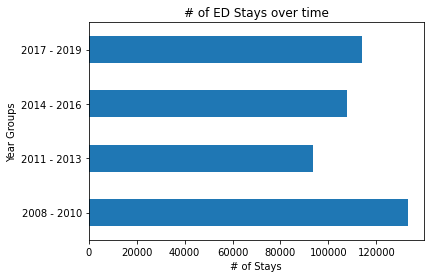

In [303]:
anch_year_to_anch_group_map = dict()
anch_year_df = hosp_patients.groupby('anchor_year').first().reset_index()
for index, row in anch_year_df.iterrows():
    anch_year_to_anch_group_map[row['anchor_year']] = row['anchor_year_group']

ed_stays['anchor_year'] = pd.to_datetime(ed_stays['intime']).apply(lambda x: x.year)
# Some anchor years do not exist. Dropping these for now: loss of .07% or 346 rows
ed_stays.drop(ed_stays[ed_stays['anchor_year'] > 2208].index, inplace = True)
ed_stays['anchor_year_group'] = ed_stays['anchor_year'].apply(lambda x: anch_year_to_anch_group_map[x])

ed_stays.anchor_year_group.value_counts().sort_index(ascending=True).plot(kind = 'barh')
plt.title("# of ED Stays over time")
plt.ylabel("Year Groups")
plt.xlabel("# of Stays")


# build anchor_year_to_group_map using hosp_patients
# create new column for edstays
# plot frequencies over year groups


# Summary of Hospital visits over the years

239


Text(0.5, 0, '# of Stays')

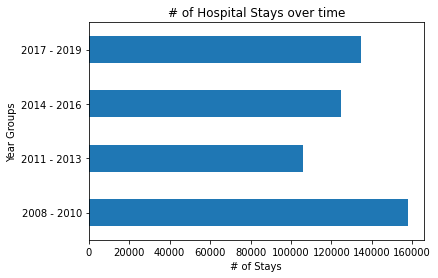

In [300]:
hosp_admissions['anchor_year'] = pd.to_datetime(hosp_admissions['admittime']).apply(lambda x: x.year)
print(len(hosp_admissions[hosp_admissions['anchor_year'] > 2208]) + len(hosp_admissions[hosp_admissions['anchor_year'] < 2109]))

# Dropping 239 rows or .04%  of stays
hosp_admissions.drop(hosp_admissions[hosp_admissions['anchor_year'] > 2208].index, inplace = True)
hosp_admissions.drop(hosp_admissions[hosp_admissions['anchor_year'] < 2109].index, inplace = True)

hosp_admissions['anchor_year_group'] = hosp_admissions['anchor_year'].apply(lambda x: anch_year_to_anch_group_map[x])
hosp_admissions.anchor_year_group.value_counts().sort_index(ascending=True).plot(kind = 'barh')
plt.title("# of Hospital Stays over time")
plt.ylabel("Year Groups")
plt.xlabel("# of Stays")


# Summary of all stays

Text(0.5, 0, '# of Stays')

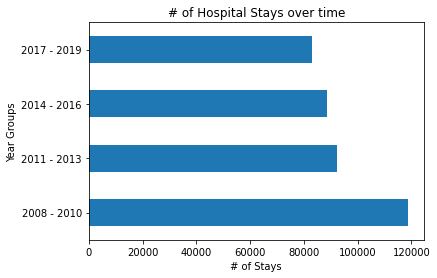

In [278]:
hosp_patients.anchor_year_group.value_counts().sort_index(ascending=True).plot(kind = 'barh')
plt.title("# of Hospital Stays over time")
plt.ylabel("Year Groups")
plt.xlabel("# of Stays")

In [297]:
hosp_patients.groupby('subject_id').anchor_year.count().max() == 1

True

In [301]:
hosp_admissions.keys()

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'hospital_expire_flag', 'anchor_year', 'anchor_year_group'], dtype='object')

In [304]:
sid_to_year_grp = pd.Series(hosp_admissions.anchor_year_group.values,index=hosp_admissions.subject_id).to_dict()
sid_to_year_grp.update(pd.Series(ed_stays.anchor_year_group.values,index=ed_stays.subject_id).to_dict())

# Summary of IPV patients over the years

In [310]:
id_type = 'subject_id'
ipv_patients = pd.DataFrame(all_subject_ids, columns=['subject_id'])
ipv_patients['ed'] = ipv_patients['subject_id'].isin(all_ed_subject_ids)
ipv_patients['hosp'] = ipv_patients['subject_id'].isin(all_hosp_subject_ids)
ipv_patients['ed_and_hosp'] = ipv_patients['ed'] * ipv_patients['hosp']
ipv_patients['ed_or_hosp'] = ipv_patients['ed'] | ipv_patients['hosp']

print("Summary")
print("# of Unique Patients: ", len(ipv_patients))
print("# of Unique Patients in ED: ", ipv_patients['ed'].value_counts()[1])
print("# of Unique Patients in Hosp: ", ipv_patients['hosp'].value_counts()[1])
print("# of Unique Patients in Both: ", ipv_patients['ed_and_hosp'].value_counts()[1])
print("---")
ipv_patients_views = []
for i, GOLD_STANDARD_IPV_CODES in enumerate([GOLD_STANDARD_IPV_CODES_1, 
                                             GOLD_STANDARD_IPV_CODES_2,
                                             GOLD_STANDARD_IPV_CODES_3,
                                             GOLD_STANDARD_IPV_CODES_4,
                                             T74_CODES,
                                             T76_CODES,
                                             Y_CODES]):
    ed_ipv_ids =  get_ids_with_icd_codes(ed_diagnoses, id_type, GOLD_STANDARD_IPV_CODES)
    hosp_ipv_ids = get_ids_with_icd_codes(hosp_diagnoses, id_type, GOLD_STANDARD_IPV_CODES)
    g_prefix = 'g' + str(i)
    
    # 
    ipv_patients_view = ipv_patients.copy()
    ipv_patients_view['ed_ipv'] = ipv_patients_view['subject_id'].isin(list(ed_ipv_ids))
    ipv_patients_view['hosp_ipv'] = ipv_patients_view['subject_id'].isin(list(hosp_ipv_ids))
    ipv_patients_view['ipv'] = ipv_patients_view['ed_ipv'] | ipv_patients_view['hosp_ipv']


    print("# of IPV Patients in ED: ", ipv_patients_view['ed_ipv'].value_counts()[1])
    print("# of IPV Patients in Hosp: ", ipv_patients_view['hosp_ipv'].value_counts()[1])
    print("# of IPV Patients in Either: ", ipv_patients_view['ipv'].value_counts()[1])
    
    print("\np(y) in ED: ", ipv_patients_view['ed_ipv'].value_counts()[1]/ipv_patients_view['ed'].value_counts()[1])
    print("p(y) in Hosp: ", ipv_patients_view['hosp_ipv'].value_counts()[1]/ipv_patients_view['ed'].value_counts()[1])
    print("p(y) in Either: ", ipv_patients_view['ipv'].value_counts()[1]/ipv_patients_view['ed_or_hosp'].value_counts()[1])
    
    ipv_patients_view['gs_set_no'] = i+1
    ipv_patients_view['anchor_year_group'] = ipv_patients_view['subject_id'].apply(lambda x: sid_to_year_grp[x])
    print(ipv_patients_view[ipv_patients_view['ipv'] == True]['anchor_year_group'].value_counts())

    print('-----\n')
    ipv_patients_views.append(ipv_patients_view)

ipv_patients = pd.concat(ipv_patients_views)
# 20 patients just went to the ED, and not the hospital

/home/t-dshanmugam/.conda/envs/ipv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Summary
# of Unique Patients:  342251
# of Unique Patients in ED:  216467
# of Unique Patients in Hosp:  255106
# of Unique Patients in Both:  129322
---
# of IPV Patients in ED:  85
# of IPV Patients in Hosp:  208
# of IPV Patients in Either:  257

p(y) in ED:  0.0003926695524029067
p(y) in Hosp:  0.0009608854929388775
p(y) in Either:  0.00075091088119538
2008 - 2010    75
2017 - 2019    69
2011 - 2013    60
2014 - 2016    53
Name: anchor_year_group, dtype: int64
-----

# of IPV Patients in ED:  92
# of IPV Patients in Hosp:  245
# of IPV Patients in Either:  298

p(y) in ED:  0.0004250070449537343
p(y) in Hosp:  0.0011318122392789663
p(y) in Either:  0.0008707060023199348
2008 - 2010    85
2017 - 2019    79
2011 - 2013    73
2014 - 2016    61
Name: anchor_year_group, dtype: int64
-----

# of IPV Patients in ED:  92
# of IPV Patients in Hosp:  247
# of IPV Patients in Either:  300

p(y) in ED:  0.0004250070449537343
p(y) in Hosp:  0.001141051522864917
p(y) in Either:  0.00087654966676

(array([157878.,      0.,      0., 185801.,      0.,      0., 145418.,
             0.,      0., 120918.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

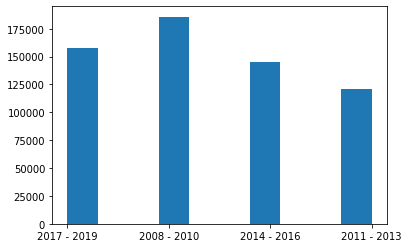

In [311]:
plt.hist(ipv_patients[(ipv_patients['ed'] == True) & (ipv_patients['hosp'] == False)]['anchor_year_group'])

(array([209055.,      0.,      0., 274365.,      0.,      0., 167174.,
             0.,      0., 229894.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

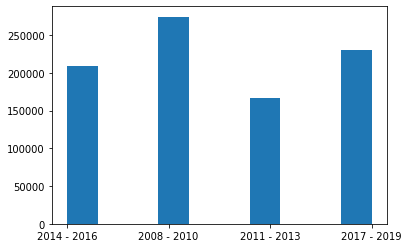

In [312]:
plt.hist(ipv_patients[(ipv_patients['ed'] == False) & (ipv_patients['hosp'] == True)]['anchor_year_group'])

(array([268737.,      0.,      0., 232344.,      0.,      0., 219506.,
             0.,      0., 184667.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

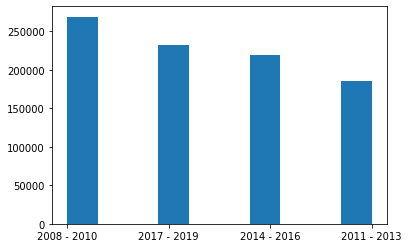

In [313]:
plt.hist(ipv_patients[(ipv_patients['ed'] == True) & (ipv_patients['hosp'] == True)]['anchor_year_group'])

[None, None, None, None, None, None, None]

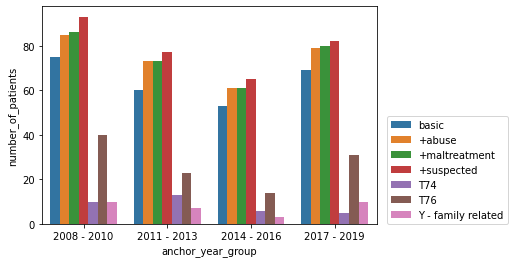

In [317]:
pos_ipv_patients = ipv_patients[ipv_patients['ipv'] == 1]
year_trends_df = pos_ipv_patients.groupby('gs_set_no')['anchor_year_group'].value_counts()
year_trends_df = year_trends_df.reset_index(name='number_of_patients')
sns.barplot(x='anchor_year_group', y='number_of_patients', hue='gs_set_no', data=year_trends_df, 
            order=['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019'])
L=plt.legend(loc=(1.03, 0))
# code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected']
code_set_names = ['t74', 't76', 'y']
code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected', 'T74', 'T76', 'Y - family related']
[L.get_texts()[i].set_text(text) for i,text in enumerate(code_set_names)]


[None, None, None, None, None, None, None]

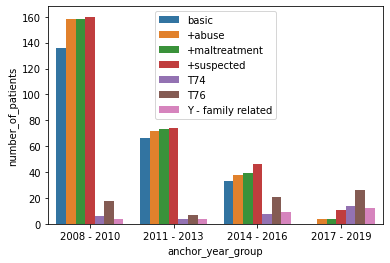

In [92]:
hosp_ipv_patients = ipv_patients[ipv_patients['hosp'] == True]
pos_hosp_ipv_patients = hosp_ipv_patients[hosp_ipv_patients['ipv'] == 1]
year_trends_df = pos_hosp_ipv_patients.groupby('gs_set_no')['anchor_year_group'].value_counts()
year_trends_df = year_trends_df.reset_index(name='number_of_patients')
sns.barplot(x='anchor_year_group', y='number_of_patients', hue='gs_set_no', data=year_trends_df, 
            order=['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019'])
L=plt.legend()
# code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected']
code_set_names = ['t74', 't76', 'y']
code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected', 'T74', 'T76', 'Y - family related']
[L.get_texts()[i].set_text(text) for i,text in enumerate(code_set_names)]


[None, None, None, None, None, None, None]

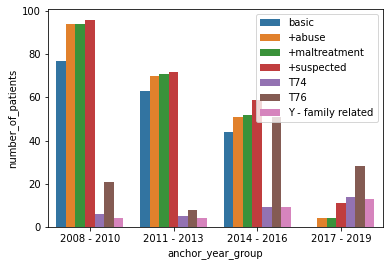

In [95]:
ed_ipv_patients = ipv_patients[ipv_patients['ed'] == True]
pos_ed_ipv_patients = ed_ipv_patients[ed_ipv_patients['ipv'] == 1]
year_trends_df = pos_ed_ipv_patients.groupby('gs_set_no')['anchor_year_group'].value_counts()
year_trends_df = year_trends_df.reset_index(name='number_of_patients')
sns.barplot(x='anchor_year_group', y='number_of_patients', hue='gs_set_no', data=year_trends_df, 
            order=['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019'])
L=plt.legend()
# code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected']
code_set_names = ['t74', 't76', 'y']
code_set_names = ['basic', '+abuse', '+maltreatment', '+suspected', 'T74', 'T76', 'Y - family related']
[L.get_texts()[i].set_text(text) for i,text in enumerate(code_set_names)]


In [79]:
year_trends_df

,gs_set_no,anchor_year_group,number_of_patients
0,1,2017 - 2019,14
1,1,2014 - 2016,9
2,1,2008 - 2010,6
3,1,2011 - 2013,5
4,2,2014 - 2016,51
5,2,2017 - 2019,28
6,2,2008 - 2010,21
7,2,2011 - 2013,8
8,3,2017 - 2019,13
9,3,2014 - 2016,9
